In [3]:
from pathlib import Path
from cc_model.load_datasets import load_gt_dataset_cached


import graph_tool.all as gt
from cc_model.wl import WL, labelings_are_equivalent
from cc_model.fast_graph import FastGraph
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [4]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [5]:
datasets = [#"karate", 
            "phonecalls",
            "HepPh", 
            "AstroPh", 
            "web-Google",
             "soc-Pokec"
#            "deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
#            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
#            "fb_pol", "facebook_sc"
           ]

In [6]:
dataset_path = Path("/home/felix/projects/colorful_configuration/datasets")

In [7]:
epsilon=1e-15
max_iter = 10_000

In [6]:
names_to_eigenvalues = {
    "karate":      6.725697727631732,
    "phonecalls" : 13.125956990198913,
    "HepPh":       20, #5.6629203197371965,
    "AstroPh":     94.4415437598996,
    "web-Google":  37.639582115220364,
    "soc-Pokec":   118.52742163417824}

In [7]:
def rewire_run_HITS_for_round(G, depth, base_hub, base_auth, *, number_of_rewires=10, verbosity=0):
    """ Calculate similarities in pagerank vectors for rewired G
    G :      FastGraph
    depth:    depth of WL iteration to be used
    in_base_pagerank :    in pagerank of G
    Generate synthethic networks which have the same WL colors as G
      at specific depth and return absolute error sum
    """
    pagerank_args = {"mode" :"in",
                     "epsilon":epsilon,
                     "max_iter":max_iter,
                     "return_err":True}
    
    auth_errors = []
    hub_errors = []
    for i in range(number_of_rewires):
        G.rewire(depth)
        
        hub, auth, err = G.calc_HITS(**pagerank_args)
        if err<0:
            print("iteration did not converge, err was", err)
            #eigenvalue = get_eigenvalue(G)
        if verbosity > 0:
            print("the error in HITS is:\r\n", err)
        diff_hub = np.sum(np.abs(hub-base_hub))
        diff_auth = np.sum(np.abs(auth-base_auth))
        #print(diff_hub, diff_auth)
        hub_errors.append(diff_hub)
        auth_errors.append(diff_auth)

    return hub_errors, auth_errors

In [8]:
def get_eigenvalue(G):
    G_gt = G.to_gt(switch=False)
    value, vector = gt.eigenvector(G_gt, epsilon = 1e-12, max_iter=1000)
    return value

def compute_HITS_on_all_datasets(n_rewires, verbosity=0):
    """ computes pagerank and compares it with rewired graphs
    """
    hub_err_values = []
    auth_err_values = []
    for dataset in datasets:
        if dataset is None:
            list_means.append([])
            list_stds.append([])
            continue
        if verbosity > 0:
            print(dataset)
        G_base = load_gt_dataset_cached(dataset_path,
                                        dataset,
                                        verbosity=verbosity,
                                        force_reload=False)
        edges = np.array(G_base.get_edges(), dtype=np.uint32)
        
        G = FastGraph(edges, G_base.is_directed())
        
        
        hub_err_vals, auth_err_vals = get_MAE_for_iterations(G,
                                        n_rewires=n_rewires)
        
        #print(hub_err_vals, auth_err_vals)
        #print(WL_fast(to_symmetric_edges(G._edges)))
        #print(G.base_partitions)
        hub_err_values.append(hub_err_vals)
        auth_err_values.append(auth_err_vals)
    return hub_err_values, auth_err_values

In [9]:
def to_symmetric_edges(edges):
    n_edges = edges.shape[0]
    out = np.empty((2 * n_edges,2), dtype=edges.dtype)
    out[:n_edges,:]=edges
    out[n_edges:,1]=edges[:,0]
    out[n_edges:,0]=edges[:,1]
    return out

In [10]:
import numpy as np
from numba import njit
from numba import int64, uint32, float64

@njit([(int64[:,:], int64, float64, int64), (uint32[:,:], int64, float64, int64, )])
def HITS_numba_sym(edges, num_nodes, epsilon, max_iter):
    """
    G: Graph
    max_iter: maximum number of iterations.
    eps: convergence parameter
    -> break iteration if L1-norm of difference between old and new pagerank vectors are smaller than eps
    """
    #num_nodes = len(degrees)

    a = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    a_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    h = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    h_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    num_iter = 0
    last_err = 1
    last_err_a = 0
    last_err_h = 0
    sum_a = 0
    sum_h = 0
    while last_err > epsilon and num_iter < max_iter:
        for i in range(num_nodes):
            a_old[i] = a[i]
            a[i] = 0
            h_old[i] = h[i]
            h[i] = 0
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            a[e1] += h_old[e2]
            a[e2] += h_old[e1]
 
        sum_a = 0
        for i in range(num_nodes):
            sum_a += a[i]
        a/=sum_a
        
        #print(sum_a)
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            h[e1] += a[e2]
            h[e2] += a[e1]


        
        sum_h = 0
        for i in range(num_nodes):
            sum_h += h[i]
        h/=sum_h
        
        # compute error
        last_err_a = 0
        for i in range(num_nodes):
            last_err_a += abs(a[i] - a_old[i])
            
        # compute error
        last_err_h = 0
        for i in range(num_nodes):
            last_err_h += abs(h[i] - h_old[i])
        
        last_err = max(last_err_h, last_err_a)
        #print(last_err)
        num_iter += 1

    if num_iter >= max_iter:
        last_err = - last_err
         #warnings.warn("Power iteration has not converged up to specified tolerance")

    return h, a, last_err, sum_h, sum_a



@njit([(int64[:,:], int64, float64, int64, float64, ), (uint32[:,:], int64, float64, int64,float64,  )])
def HITS_numba_sym_shift(edges, num_nodes, epsilon, max_iter, shift):
    """
    G: Graph
    max_iter: maximum number of iterations.
    eps: convergence parameter
    -> break iteration if L1-norm of difference between old and new pagerank vectors are smaller than eps
    """
    #num_nodes = len(degrees)

    a = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    a_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    h = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    h_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    num_iter = 0
    last_err = 1
    last_err_a = 0
    last_err_h = 0
    while last_err > epsilon and num_iter < max_iter:
        for i in range(num_nodes):
            a_old[i] = a[i]
            a[i] = shift * a[i]
            h_old[i] = h[i]
            h[i] = shift * h[i]
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            a[e1] += h_old[e2]
            a[e2] += h_old[e1]
 
        sum_a = 0
        for i in range(num_nodes):
            sum_a += a[i]
        a/=sum_a
        
        #print(sum_a)
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            h[e1] += a[e2]
            h[e2] += a[e1]


        
        sum_h = 0
        for i in range(num_nodes):
            sum_h += h[i]
        h/=sum_h
        
        # compute error
        last_err_a = 0
        for i in range(num_nodes):
            last_err_a += abs(a[i] - a_old[i])
            
        # compute error
        last_err_h = 0
        for i in range(num_nodes):
            last_err_h += abs(h[i] - h_old[i])
        
        last_err = max(last_err_h, last_err_a)
        #print(last_err)
        num_iter += 1

    if num_iter >= max_iter:
        last_err = - last_err
         #warnings.warn("Power iteration has not converged up to specified tolerance")

    return h, a, last_err, sum_h, sum_a



@njit([(int64[:,:], int64, float64, int64), (uint32[:,:], int64, float64, int64, )])
def HITS_numba_dir(edges, num_nodes, epsilon, max_iter):
    """
    G: Graph
    max_iter: maximum number of iterations.
    eps: convergence parameter
    -> break iteration if L1-norm of difference between old and new pagerank vectors are smaller than eps
    """
    a = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    a_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    h = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    h_old = 1/num_nodes * np.ones(num_nodes, dtype=np.float64)
    
    num_iter = 0
    last_err = 1
    while last_err > epsilon and num_iter < max_iter:
        for i in range(num_nodes):
            a_old[i] = a[i]
            a[i] = 0
            h_old[i] = h[i]
            h[i] = 0
        
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
#            a[e1] += h_old[e2]
            a[e2] += h_old[e1]
         
        sum_a = 0
        for i in range(num_nodes):
            sum_a += a[i]
        a/=sum_a
    
        for i in range(edges.shape[0]):
            e1 = edges[i,0]
            e2 = edges[i,1]
            h[e1] += a[e2]
#            h[e2] += a[e1]


        
        sum_h = 0
        for i in range(num_nodes):
            sum_h += h[i]
        h/=sum_h
        
        # compute error
        last_err_a = 0
        for i in range(num_nodes):
            last_err_a += abs(a[i] - a_old[i])
            
        # compute error
        last_err_h = 0
        for i in range(num_nodes):
            last_err_h += abs(h[i] - h_old[i])
        
        last_err = max(last_err_h, last_err_a)
        num_iter += 1

    if num_iter >= max_iter:
        last_err = - last_err
         #warnings.warn("Power iteration has not converged up to specified tolerance")

    return h, a, last_err


In [11]:
def katz_dict_to_array(d):
    arr = np.zeros(len(d))
    for key, value in d.items():
        arr[key] = value
    return arr

In [12]:
from networkx.algorithms.link_analysis.hits_alg import _hits_python

In [13]:
def get_MAE_for_iterations(G, n_rewires):
    hub_values = []
    auth_values = []
    G.ensure_edges_prepared(initial_colors=None, both=True)
    #print(G.dead_arr.sum(axis=1)/G._edges.shape[0])
    in_base_hubs, in_base_auth, err = G.calc_HITS("base",
                              epsilon=epsilon,
                             max_iter=max_iter,
                              return_err=True)
    print("base_err", err)
    compare_to_nx = False
    if compare_to_nx:
        G_nx = G.to_nx(switch=False)
        import networkx as nx
        hubs_dict, auth_dict = _hits_python(G_nx,
                                       normalized=False,
                                       tol = epsilon*G_nx.number_of_nodes(),
                                           max_iter=max_iter)
        #vector = np.array(vector.get_array())
        #vector = vector/sum(vector)
        hubs_arr = katz_dict_to_array(hubs_dict)
        hubs_arr=hubs_arr/np.sum(hubs_arr)
        
        auth_arr = katz_dict_to_array(auth_dict)
        auth_arr=auth_arr/np.sum(auth_arr)
        print("in_base_hubs", in_base_hubs)
        print("hubs_dict", hubs_arr)
        
        
        
        print("in_base_auth", in_base_auth)
        print("auth_dict", auth_arr)
        #return []
        #print(in_base_ev, err)
        print("max_hubs_error", (in_base_hubs - hubs_arr).max())
        print("max_auth_error", (in_base_auth - auth_arr).max())
    print("total WL iterations ", G.wl_iterations)
    #print(G.base_partitions.shape)
    #print(G.edges.shape)
    for WL_round in range(G.wl_iterations-1,-1,-1):
        if verbosity>0:
            print("WL round", WL_round)

        Hubs, Auths = rewire_run_HITS_for_round(G,
                                             WL_round,
                                             in_base_hubs,
                                             in_base_auth,
                                             number_of_rewires=n_rewires,
                                             verbosity=0)
        #print(MAEs)
        hub_values.append(Hubs)
        auth_values.append(Auths)
    return hub_values, auth_values

In [14]:
from scipy.sparse.linalg import eigsh, svds

In [15]:
from scipy.sparse import coo_matrix

In [16]:
def to_coo(self,):
    if self.is_directed:
        return coo_matrix((np.ones(self.edges.shape[0]), (self.edges[:,0], self.edges[:,1])), shape = (self.num_nodes, self.num_nodes))
    else:
        edges=self.edges
        edges2 = np.vstack((edges[:,1], edges[:,0])).T
        edges = np.vstack((edges, edges2))
        return coo_matrix((np.ones(edges.shape[0]), (edges[:,0], edges[:,1])), shape = (self.num_nodes, self.num_nodes))
FastGraph.to_coo = to_coo

In [17]:
def normalize(v):
    v = v.flatten().real
    v_sum = np.sum(v)
    if v_sum <0:
        v*=-1
    v = np.maximum(v, 0)
    v/=np.sum(np.abs(v))
    return v

def calc_HITS(self, mode, epsilon, max_iter, return_err=False):
    if not self.is_directed:
        m = self.to_coo()
        w, v = eigsh(m, k=1, tol=0, maxiter=max_iter, v0=np.full(self.num_nodes,1/self.num_nodes))
        #print(w, v)
        #print(v.shape)
        hubs = normalize(v[:])
        auth = hubs
        err=0
    else:

        if "base" in mode:
            edges = self._edges
        else:
            edges = self.edges
        m = self.to_coo()
        left, s, right = svds(m, k=1, tol=0, maxiter=max_iter, v0=np.full(self.num_nodes,1/self.num_nodes))
        #print(left, right)
        #print(left.shape, right.shape)
        hubs = normalize(left)
        auth = normalize(right)
        if False: # check that h2 and hubs agree
            h2 = m * auth
            h2/=h2.sum()
            print((h2 - hubs).sum())
            
        err = 0
        #print(hubs, auth)
        #hubs, auth, err =  HITS_numba_dir(edges,
        #                                len(self.in_degree),
        #                                epsilon,
        #                                max_iter)
    if return_err:
        return hubs, auth, err
    else:
        return hubs, auth
FastGraph.calc_HITS = calc_HITS

In [18]:
from cc_model.fast_wl import WL_both
def calc_wl_both(self, edges = None, initial_colors=None):
    if edges is None:
        edges = self.edges
    if not self.is_directed:
        edges2 = np.vstack((edges[:,1], edges[:,0])).T
        edges = np.vstack((edges, edges2))

    if type(initial_colors).__module__ == np.__name__:
        return WL_both(edges, labels = initial_colors)
    elif initial_colors is not None and "out_degree" in initial_colors:
        return WL_both(edges, labels = self.out_degree)
    else:
        return WL_both(edges)

FastGraph.calc_wl_both = calc_wl_both

In [19]:
from cc_model.fast_wl import WL_fast

verbosity=1
number_of_samples = 100
list_values, list_values2 = compute_HITS_on_all_datasets(number_of_samples, verbosity=1)

phonecalls
resetting
base_err 0
total WL iterations  9
WL round 8
WL round 7
WL round 6
WL round 5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
HepPh
resetting
base_err 0
total WL iterations  5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0
AstroPh
resetting
base_err 0
total WL iterations  5
WL round 4
WL round 3
WL round 2
WL round 1
WL round 0


In [20]:
print(list_values)

[[[1.2365526978487308e-14, 1.1276125577305006e-14, 5.3814883540956926e-15, 5.414185262978235e-15, 1.0821891082457728e-14, 1.045318297345399e-14, 7.743318989235719e-15, 7.341121319022942e-15, 1.3719603930073605e-14, 1.1183810312918946e-14], [9.21868210154516e-15, 9.53554587271918e-15, 3.870271513176995e-15, 7.107966558869667e-15, 1.1038024760931918e-14, 1.39242639462861e-14, 4.838709085806757e-15, 8.396156549310652e-15, 6.492504824772445e-15, 1.0002717774907764e-14], [3.5522917040154613e-13, 3.5472721003103697e-13, 2.3926673389030415e-13, 2.4763609502943405e-13, 2.0886508596750906e-13, 2.316904710582149e-13, 3.703770893705312e-13, 3.5764343471380507e-13, 1.1344351652310788e-13, 8.869903008866242e-15], [1.0432230203795292e-11, 1.836278562699565e-11, 1.028564915030472e-11, 1.262058362266036e-11, 2.028077459521788e-11, 3.663984689016661e-11, 1.0048575806424597e-11, 3.940947904606128e-11, 2.4625961350489555e-11, 1.0715594455577779e-10], [8.582945180379917e-08, 4.897587021420887e-08, 6.15340

In [21]:
print(list_values2)

[[[1.2365526978487308e-14, 1.1276125577305006e-14, 5.3814883540956926e-15, 5.414185262978235e-15, 1.0821891082457728e-14, 1.045318297345399e-14, 7.743318989235719e-15, 7.341121319022942e-15, 1.3719603930073605e-14, 1.1183810312918946e-14], [9.21868210154516e-15, 9.53554587271918e-15, 3.870271513176995e-15, 7.107966558869667e-15, 1.1038024760931918e-14, 1.39242639462861e-14, 4.838709085806757e-15, 8.396156549310652e-15, 6.492504824772445e-15, 1.0002717774907764e-14], [3.5522917040154613e-13, 3.5472721003103697e-13, 2.3926673389030415e-13, 2.4763609502943405e-13, 2.0886508596750906e-13, 2.316904710582149e-13, 3.703770893705312e-13, 3.5764343471380507e-13, 1.1344351652310788e-13, 8.869903008866242e-15], [1.0432230203795292e-11, 1.836278562699565e-11, 1.028564915030472e-11, 1.262058362266036e-11, 2.028077459521788e-11, 3.663984689016661e-11, 1.0048575806424597e-11, 3.940947904606128e-11, 2.4625961350489555e-11, 1.0715594455577779e-10], [8.582945180379917e-08, 4.897587021420887e-08, 6.15340

In [22]:
print()
now = datetime.now()
if number_of_samples > 51:
    save_prefix = now.strftime("%Y_%m_%d__%H_%M_%S")
    out_name = "./results/"+"_HITS_"+save_prefix+".pkl"
    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump((list_values, list_values2,  datasets), f)

In [8]:
def get_mean_std(list_values):
    list_means = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        mean = np.mean(values)+1e-20
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        list_means.append(mean)
        list_stds0.append(quantiles[0])
        list_stds1.append(quantiles[1])
    list_stds = [list_stds0[::-1], list_stds1[::-1]]
    return list_means[::-1], list_stds

def quickplot(list_values, datasets, show_alpha=False, save_date=None, xlim=None):
    plt.figure(figsize=(10,6))
    if show_alpha:
        x=np.linspace(0,15)
        y=2 *alpha**(x+1)
        plt.plot(x,y)
    
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "_"]
    marker_sizes = 6*np.array([1.4, 1, 1.5, 1, 1.9,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes):
        means, stds = get_mean_std(values)
        #inds = stds[((means-stds)/means)<1e-4]
        #stds = np.minimum(stds, means-1e-20)
        plt.errorbar(x=np.arange(len(means)),y=means, yerr=stds, label=label, fmt=marker+"--", markersize=ms)


    plt.ylabel("SAE of HITS")
    plt.xlabel("WL-iteration preserved exactly")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.yscale("log")
    plt.legend()
    #
    if save_date is None:
        plt.title("Convergence of Katz for synthetic networks ")
    else:
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'eigenvector_{time_str}.pdf', bbox_inches = 'tight')
    

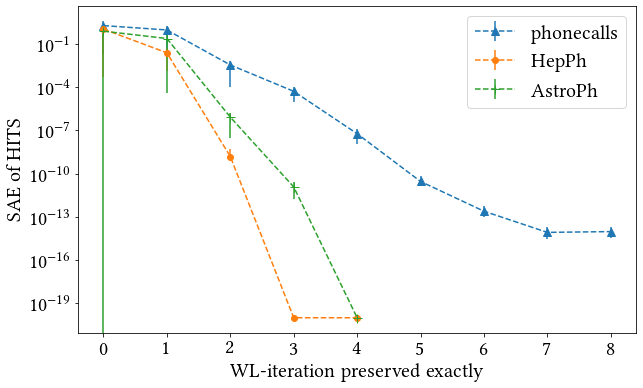

In [24]:
quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now())

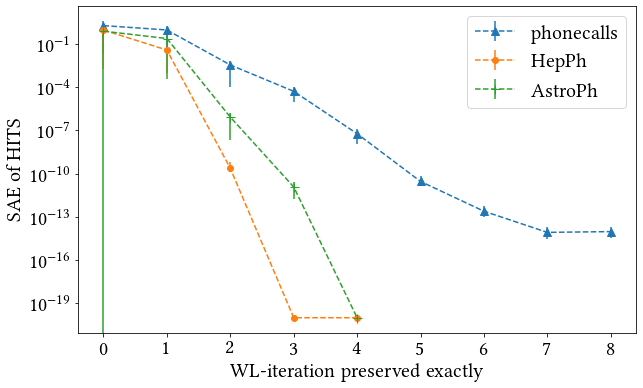

In [25]:
quickplot(list_values2, datasets, show_alpha=False, save_date=datetime.now())

In [10]:
#./results/_HITS_2022_02_03__23_58_26.pkl
load_dataset=True
if load_dataset:
    load_date = datetime(2022,2,3, 23,58,26)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")
    with open("./results/"+"_HITS_"+save_prefix+".pkl", "rb") as f:
        (l_list_values1, l_list_values2, datasets2) = pickle.load(f)

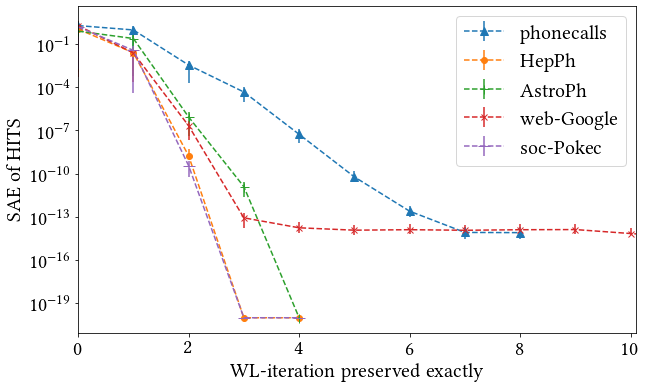

In [12]:
quickplot(l_list_values1, datasets2, save_date=load_date, xlim=(0,10.1))

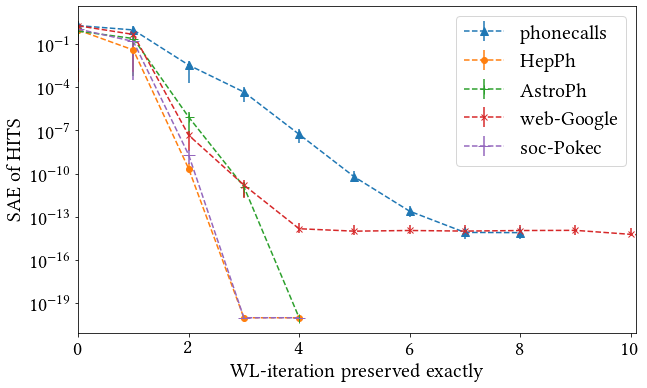

In [13]:
quickplot(l_list_values2, datasets2, save_date=load_date, xlim=(0,10.1))